# Microcontroller Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [2]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
#!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
#!pip install cython pyyaml==5.1
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
#!gcc --version
# opencv is pre-installed on colab

'1.6.0'

In [3]:
# install detectron2:
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

## Get data

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [5]:
#!wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
#!unzip microcontroller_segmentation_data.zip
#!ls

In [6]:
#!ls 'Microcontroller Segmentation'

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [7]:
from detectron2.data.datasets import register_coco_instances

for d in ["test"]:
    register_coco_instances(f"microcontroller_{d}", 
                            {}, 
                            f"/home/ubuntu/data/coco_set/{d}/annotations.json",
                            f"/home/ubuntu/data/coco_set/{d}")

In [8]:
for d in ["train"]:
    register_coco_instances(f"microcontroller_{d}", 
                            {}, 
                            f"/home/ubuntu/data/coco_set/{d}/annotations.json",
                            f"/home/ubuntu/data/coco_set/{d}")

WARNING [08/28 09:55:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/28 09:55:10 d2.data.datasets.coco]: Loaded 10 images in COCO format from /home/ubuntu/data/coco_set/test/annotations.json
/home/ubuntu/data/coco_set/test/JPEGImages/20190731_091636.jpg


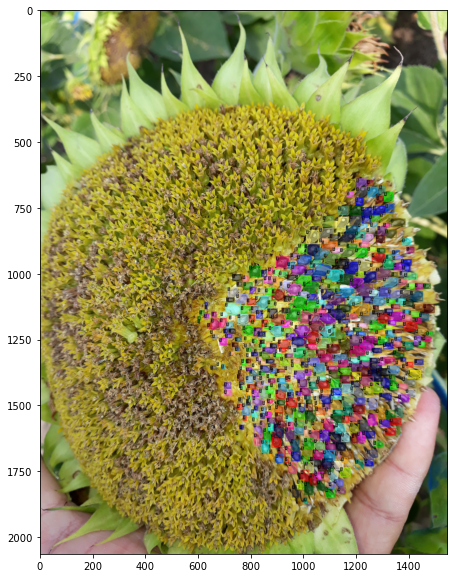

/home/ubuntu/data/coco_set/test/JPEGImages/20190731_091237.jpg


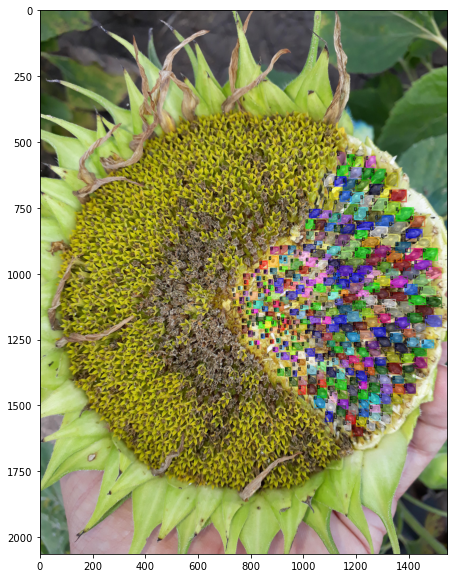

/home/ubuntu/data/coco_set/test/JPEGImages/20190731_091252.jpg


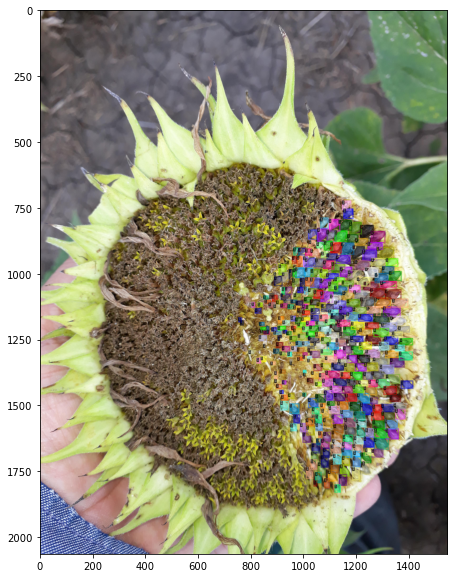

In [9]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("microcontroller_test")
microcontroller_metadata = MetadataCatalog.get("microcontroller_test")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ("microcontroller_test",)
cfg.DATALOADER.NUM_WORKERS = 16
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train()

[08/28 09:55:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [42]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 7000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 7000 
cfg.DATASETS.TEST = ("microcontroller_test", )
cfg.TEST.DETECTIONS_PER_IMAGE = 7000
predictor = DefaultPredictor(cfg)

WARNING [08/28 10:09:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/28 10:09:47 d2.data.datasets.coco]: Loaded 73 images in COCO format from /home/ubuntu/data/coco_set/train/annotations.json
/home/ubuntu/data/coco_set/train/JPEGImages/20190731_100212.jpg
0:00:10.320514


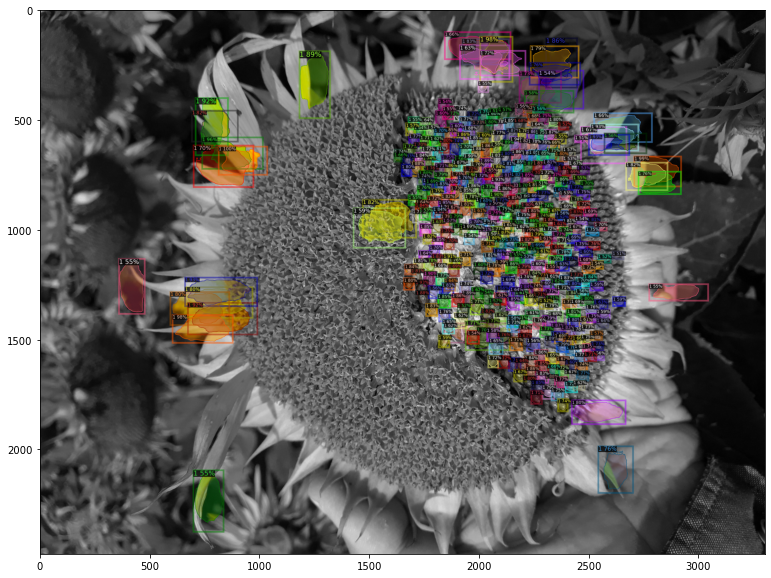

In [43]:
from detectron2.utils.visualizer import ColorMode
from datetime import datetime

def compute_resize_scale(image_shape, min_side=800, max_side=1333):
    """ Compute an image scale such that the image size is constrained to min_side and max_side.
    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.
    Returns
        A resizing scale.
    """
    (rows, cols, _) = image_shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    return scale

def resize_image(img, min_side=800, max_side=1333):
    """ Resize an image such that the size is constrained to min_side and max_side.
    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.
    Returns
        A resized image.
    """
    # compute scale to resize the image
    scale = compute_resize_scale(img.shape, min_side=min_side, max_side=max_side)

    # resize the image with the computed scale
    img = cv2.resize(img, None, fx=scale, fy=scale)

    return img, scale


dataset_dicts = DatasetCatalog.get("microcontroller_train")
for d in random.sample(dataset_dicts, 1): 
    d["file_name"] = "/home/ubuntu/data/coco_set/train/JPEGImages/20190731_100212.jpg"
    im = cv2.imread(d["file_name"])
    #im, scale = resize_image(im)
    print(d["file_name"])
    start = datetime.now()
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(datetime.now() - start)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

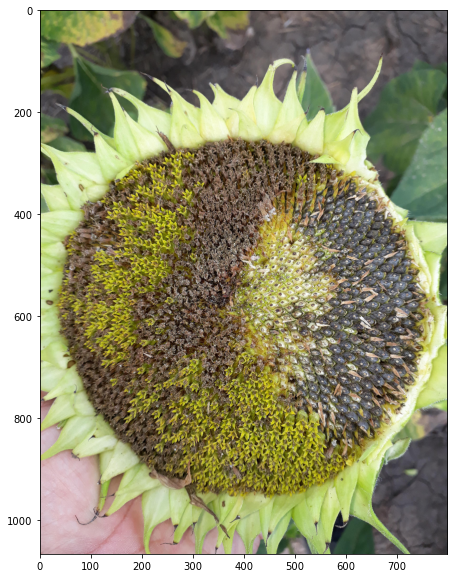

800 1067
259 259


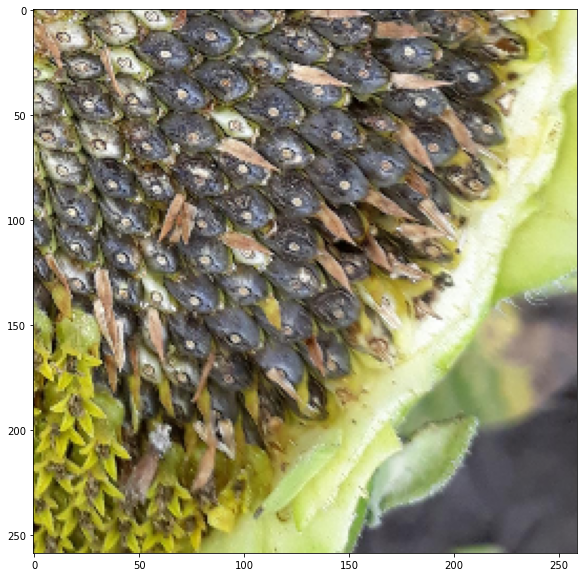

800 1067


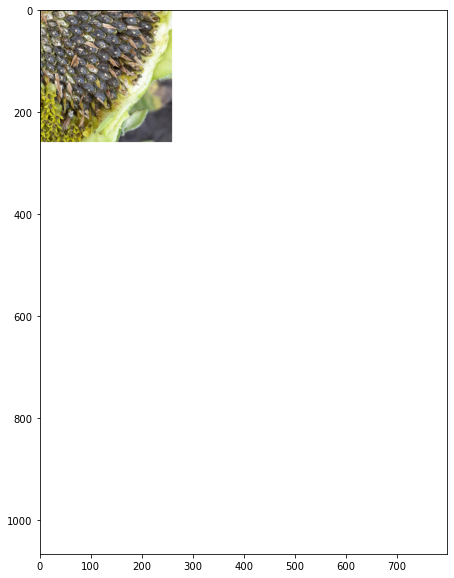

In [77]:
def create_blank(image, w, h, color=(255, 255, 255)):
    """Create new image(numpy array) filled with certain color in BGR"""
    r_image = np.zeros((h, w, 3), np.uint8)
    r_image[:] = color
    r_image[:image.shape[0],:image.shape[1],:image.shape[2]] = image
    return r_image

img = cv2.imread("/home/ubuntu/data/coco_set/test/JPEGImages/20190731_091229.jpg")
img, scale = resize_image(img)

plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

(y, x, _) = img.shape
print(x, y)

crop_img = img[int(2500*scale):int(3500*scale), int(2000*scale):int(3000*scale)]
(y_c, x_c, _) = crop_img.shape
print(x_c, y_c)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
plt.show()

black_img = create_blank(crop_img, x, y)
(y, x, _) = img.shape
print(x, y)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB))
plt.show()

0:00:00.243639


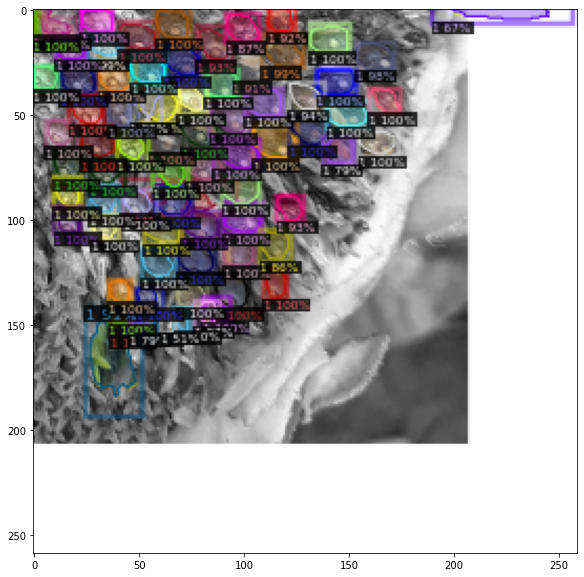

In [78]:
outputs = predictor(black_img)
v = Visualizer(black_img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
start = datetime.now()
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print(datetime.now() - start)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:259, :259, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [70]:
outputs["instances"]

Instances(num_instances=96, image_height=1067, image_width=800, fields=[pred_boxes: Boxes(tensor([[1.9339e+02, 2.0276e+02, 2.1876e+02, 2.1848e+02],
        [5.7955e+00, 1.3660e+02, 2.6334e+01, 1.5149e+02],
        [2.0039e+02, 1.7646e+02, 2.2264e+02, 1.9334e+02],
        [1.5483e+02, 1.9336e+02, 1.7805e+02, 2.1110e+02],
        [1.0080e+02, 1.6498e+02, 1.2818e+02, 1.8303e+02],
        [8.8888e+01, 1.9579e+02, 1.1144e+02, 2.1150e+02],
        [8.9350e+01, 2.1521e+02, 1.1333e+02, 2.3600e+02],
        [3.9862e+01, 1.6174e+02, 6.1356e+01, 1.7941e+02],
        [3.4865e+01, 2.1889e+02, 5.5760e+01, 2.3623e+02],
        [1.8041e+02, 1.8543e+02, 2.0235e+02, 1.9932e+02],
        [1.7012e+02, 1.6395e+02, 1.9710e+02, 1.7989e+02],
        [1.6421e+02, 1.3895e+02, 1.9432e+02, 1.5782e+02],
        [1.3261e+01, 1.4963e+02, 3.4744e+01, 1.6270e+02],
        [1.1302e+02, 2.0736e+02, 1.3508e+02, 2.2805e+02],
        [6.3834e+01, 1.7636e+02, 8.8058e+01, 1.9476e+02],
        [7.8845e+01, 1.5320e+02, 1.0283e